In [2]:
import numpy as np

In [3]:
np.__file__, np.__version__

('/Users/kunal21/opt/miniconda3/envs/gnnnlp/lib/python3.10/site-packages/numpy/__init__.py',
 '1.24.1')

#### TF TEST

In [4]:
import tensorflow as tf

In [5]:
tf.reduce_sum(tf.random.normal([1000, 1000]))

Metal device set to: Apple M1 Pro


2023-01-01 08:58:49.369353: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-01 08:58:49.369413: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<tf.Tensor: shape=(), dtype=float32, numpy=782.32025>

In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
import torch
torch.__version__

'1.13.1'

In [8]:
import transformers as tr
tr.__version__ 

'4.25.1'

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import os
import re

##### 
- Downloading a text dataset
- Visualizing text data
- Converting text into numbers using tokenization
- Turning our tokenized text into an embedding
- Modelling a text dataset
- Starting with a baseline (TF-IDF)
- Building several deep learning text models
- Dense, LSTM, GRU, Conv1D, Transfer learning
- Comparing the performance of each our models
- Combining our models into an ensemble
- Saving and loading a trained model
- Find the most wrong predictions

### Data Pre-Processing

In [10]:
book =[]
with open('TheAlchemist.txt', mode='r') as file:
    book=file.readlines()

book    

['The Alchemist\n',
 '\n',
 'Paulo Coelho\n',
 '\n',
 'Translated by Alan R. Clarke. Published 1992. ISBN 0-7225-3293-8.\n',
 '\n',
 'CONTENTS\n',
 '\n',
 'Part One\n',
 'Part Two\n',
 'Epilogue\n',
 '\n',
 'PART ONE\n',
 '\n',
 '\n',
 '\n',
 "The boy's name was Santiago . Dusk was falling as the boy arrived with his herd at an abandoned\n",
 'church. The roof had fallen in long ago, and an enormous sycamore had grown on the spot where the\n',
 'sacristy had once stood.\n',
 '\n',
 'He decided to spend the night there. He saw to it that all the sheep entered through the ruined gate, and\n',
 'then laid some planks across it to prevent the flock from wandering away during the night. There were no\n',
 'wolves in the region, but once an animal had strayed during the night, and the boy had had to spend the\n',
 'entire next day searching for it.\n',
 '\n',
 'He swept the floor with his jacket and lay down, using the book he had just finished reading as a pillow.\n',
 'He told himself that

In [11]:
len(book)

3808

#### re-formatting sentences 

In [12]:
sentence_list = ['\n']

for x in range(0,len(book)):    
    if (book[x] =='\n'):
        sentence_list.append(book[x])
    else:
        if(sentence_list[-1]!='\n'):
            sentence_list[-1] = (sentence_list[-1]+' '+ book[x]).replace('\n','')
        else:
            sentence_list.append(book[x].replace('\n',''))
        
sentence_list   

['\n',
 'The Alchemist',
 '\n',
 'Paulo Coelho',
 '\n',
 'Translated by Alan R. Clarke. Published 1992. ISBN 0-7225-3293-8.',
 '\n',
 'CONTENTS',
 '\n',
 'Part One Part Two Epilogue',
 '\n',
 'PART ONE',
 '\n',
 '\n',
 '\n',
 "The boy's name was Santiago . Dusk was falling as the boy arrived with his herd at an abandoned church. The roof had fallen in long ago, and an enormous sycamore had grown on the spot where the sacristy had once stood.",
 '\n',
 'He decided to spend the night there. He saw to it that all the sheep entered through the ruined gate, and then laid some planks across it to prevent the flock from wandering away during the night. There were no wolves in the region, but once an animal had strayed during the night, and the boy had had to spend the entire next day searching for it.',
 '\n',
 'He swept the floor with his jacket and lay down, using the book he had just finished reading as a pillow. He told himself that he would have to start reading thicker books: they laste

In [13]:
len(sentence_list)

2344

In [14]:
3808 - 2344 #no of sentences for summarization after formatting - also contains \n - to be removed further

1464

In [15]:
def get_words(input_sentences_list):
    words_list =[]

    [words_list.append(len(x)) for x in input_sentences_list]
    words_list.sort()

    print('sentenaces - min length : '+ str(words_list[0]) + ' max length : '+ str(words_list[-1]), ' mean - ', np.mean(words_list))

get_words(sentence_list)

sentenaces - min length : 1 max length : 1177  mean -  89.06100682593856


#### Extrating Chapters

In [16]:
chapters = [y[0] for y in [re.findall(r'\b[A-Z]+(?:\s+[A-Z]+)*\b',x) for x in sentence_list] if len(y)>0 and len(y[0])>1]
chapters

['CONTENTS', 'PART ONE', 'PART TWO', 'EPILOGUE']

In [17]:
sentence_list[0:sentence_list.index('PART ONE')]

['\n',
 'The Alchemist',
 '\n',
 'Paulo Coelho',
 '\n',
 'Translated by Alan R. Clarke. Published 1992. ISBN 0-7225-3293-8.',
 '\n',
 'CONTENTS',
 '\n',
 'Part One Part Two Epilogue',
 '\n']

In [18]:
len(chapters)

4

#### creating book dataset

In [19]:
book_dict = {}

start_index = 0
for b in range(0,len(chapters)):
    if b < len(chapters)-1:           
        book_dict[chapters[b]] = sentence_list[start_index:sentence_list.index(chapters[b+1])]
        start_index = sentence_list.index(chapters[b+1])+1
    else:
        book_dict[chapters[b]] = sentence_list[start_index:]
    
    
    
book_dict   

{'CONTENTS': ['\n',
  'The Alchemist',
  '\n',
  'Paulo Coelho',
  '\n',
  'Translated by Alan R. Clarke. Published 1992. ISBN 0-7225-3293-8.',
  '\n',
  'CONTENTS',
  '\n',
  'Part One Part Two Epilogue',
  '\n'],
 'PART ONE': ['\n',
  '\n',
  '\n',
  "The boy's name was Santiago . Dusk was falling as the boy arrived with his herd at an abandoned church. The roof had fallen in long ago, and an enormous sycamore had grown on the spot where the sacristy had once stood.",
  '\n',
  'He decided to spend the night there. He saw to it that all the sheep entered through the ruined gate, and then laid some planks across it to prevent the flock from wandering away during the night. There were no wolves in the region, but once an animal had strayed during the night, and the boy had had to spend the entire next day searching for it.',
  '\n',
  'He swept the floor with his jacket and lay down, using the book he had just finished reading as a pillow. He told himself that he would have to start re

In [20]:
book_dict.keys()

dict_keys(['CONTENTS', 'PART ONE', 'PART TWO', 'EPILOGUE'])

In [21]:
book_dict.get('PART ONE')

['\n',
 '\n',
 '\n',
 "The boy's name was Santiago . Dusk was falling as the boy arrived with his herd at an abandoned church. The roof had fallen in long ago, and an enormous sycamore had grown on the spot where the sacristy had once stood.",
 '\n',
 'He decided to spend the night there. He saw to it that all the sheep entered through the ruined gate, and then laid some planks across it to prevent the flock from wandering away during the night. There were no wolves in the region, but once an animal had strayed during the night, and the boy had had to spend the entire next day searching for it.',
 '\n',
 'He swept the floor with his jacket and lay down, using the book he had just finished reading as a pillow. He told himself that he would have to start reading thicker books: they lasted longer, and made more comfortable pillows.',
 '\n',
 'It was still dark when he awoke, and, looking up, he could see the stars through the half-destroyed roof.',
 '\n',
 'I wanted to sleep a little long

In [22]:
epilogue = book_dict['EPILOGUE']
epilogue

['\n',
 '\n',
 '\n',
 'The boy reached the small, abandoned church just as night was falling. The sycamore was still there in the sacristy, and the stars could still be seen through the half-destroyed roof. He remembered the time he had been there with his sheep; it had been a peaceful night. . . except for the dream.',
 '\n',
 'Now he was here not with his flock, but with a shovel.',
 '\n',
 'He sat looking at the sky for a long time. Then he took from his knapsack a bottle of wine, and drank some. He remembered the night in the desert when he had sat with the alchemist, as they looked at the stars and drank wine together. He thought of the many roads he had traveled, and of the strange way God had chosen to show him his treasure. If he hadn\'t believed in the significance of recurrent dreams, he would not have met the Gypsy woman, the king, the thief, or. . . "Well, it\'s a long list. But the path was written in the omens, and there was no way I could go wrong," he said to himself.',

In [23]:
book_dict.get('CONTENTS')

['\n',
 'The Alchemist',
 '\n',
 'Paulo Coelho',
 '\n',
 'Translated by Alan R. Clarke. Published 1992. ISBN 0-7225-3293-8.',
 '\n',
 'CONTENTS',
 '\n',
 'Part One Part Two Epilogue',
 '\n']

In [24]:
#'NO OF SENTENCES PER SECTION OF BOOK = '
[ x +' : '+ str(len(book_dict.get(x))) for x in book_dict.keys()]

['CONTENTS : 11', 'PART ONE : 623', 'PART TWO : 1679', 'EPILOGUE : 28']

#### EXTRATING PARAGRAPHS FOR SUMMARIZATION

 -  As observed from data, there is 3 lines of gap between paragraphs, so extracting paragraph list for summarization


In [25]:
book_dict_paragraphs ={}

for x in book_dict.keys():
    paragraph_list=[]
    next_line_counter = 0
    for line in book_dict.get(x):            
        if line != '\n':
            if next_line_counter==3:
                paragraph_list.append(line) 
            else:                
                if len(paragraph_list)!=0:
                        paragraph_list[-1]=paragraph_list[-1]+' '+line
                else:
                    paragraph_list.append(line)
            next_line_counter=0
        else:                
            next_line_counter+=1


    book_dict_paragraphs[x] = paragraph_list
    paragraph_list=[]

            
book_dict_paragraphs.get('PART ONE')[0]

'The boy\'s name was Santiago . Dusk was falling as the boy arrived with his herd at an abandoned church. The roof had fallen in long ago, and an enormous sycamore had grown on the spot where the sacristy had once stood. He decided to spend the night there. He saw to it that all the sheep entered through the ruined gate, and then laid some planks across it to prevent the flock from wandering away during the night. There were no wolves in the region, but once an animal had strayed during the night, and the boy had had to spend the entire next day searching for it. He swept the floor with his jacket and lay down, using the book he had just finished reading as a pillow. He told himself that he would have to start reading thicker books: they lasted longer, and made more comfortable pillows. It was still dark when he awoke, and, looking up, he could see the stars through the half-destroyed roof. I wanted to sleep a little longer, he thought. He had had the same dream that night as a week ag

In [26]:
book_dict_paragraphs.keys()

dict_keys(['CONTENTS', 'PART ONE', 'PART TWO', 'EPILOGUE'])

In [27]:
print('comparing sentences list with paragraphs after formatting')

for x in book_dict.keys():
    print(x, 'book_dict :: ',len(book_dict.get(x)) ,'book_dict_paragraphs :: ',len(book_dict_paragraphs.get(x)))

comparing sentences list with paragraphs after formatting
CONTENTS book_dict ::  11 book_dict_paragraphs ::  1
PART ONE book_dict ::  623 book_dict_paragraphs ::  32
PART TWO book_dict ::  1679 book_dict_paragraphs ::  74
EPILOGUE book_dict ::  28 book_dict_paragraphs ::  1


##### Finding out average length of words for each sentence for tokenization

In [28]:
[ get_words(book_dict_paragraphs.get(keys)) for keys in book_dict_paragraphs.keys()]

sentenaces - min length : 128 max length : 128  mean -  128.0
sentenaces - min length : 353 max length : 3355  mean -  1840.3125
sentenaces - min length : 31 max length : 13349  mean -  1979.2297297297298
sentenaces - min length : 2927 max length : 2927  mean -  2927.0


[None, None, None, None]

In [29]:

for keys in book_dict_paragraphs.keys():
    print('\n'+keys)
    get_words(book_dict_paragraphs.get(keys))
    print('\n')
    print(max(book_dict_paragraphs.get(keys), key=len))



CONTENTS
sentenaces - min length : 128 max length : 128  mean -  128.0


The Alchemist Paulo Coelho Translated by Alan R. Clarke. Published 1992. ISBN 0-7225-3293-8. CONTENTS Part One Part Two Epilogue

PART ONE
sentenaces - min length : 353 max length : 3355  mean -  1840.3125


The sun began its departure, as well. The boy watched it through its trajectory for some time, until it was hidden behind the white houses surrounding the plaza. He recalled that when the sun had risen that morning, he was on another continent, still a shepherd with sixty sheep, and looking forward to meeting with a girl. That morning he had known everything that was going to happen to him as he walked through the familiar fields. But now, as the sun began to set, he was in a different country, a stranger in a strange land, where he couldn't even speak the language. He was no longer a shepherd, and he had nothing, not even the money to return and start everything over. All this happened between sunrise and su

In [30]:
len(book_dict_paragraphs.get('EPILOGUE')[0])

2927

In [31]:
MAX_LENGTH = 2048
MIN_LENGTH = 32

### USING TRASNSFORMERS FOR SUMMARIZATION

#### USING PEGASUS

In [32]:
from transformers import pipeline

In [33]:
book_dict_paragraphs.get('PART ONE')[0]

'The boy\'s name was Santiago . Dusk was falling as the boy arrived with his herd at an abandoned church. The roof had fallen in long ago, and an enormous sycamore had grown on the spot where the sacristy had once stood. He decided to spend the night there. He saw to it that all the sheep entered through the ruined gate, and then laid some planks across it to prevent the flock from wandering away during the night. There were no wolves in the region, but once an animal had strayed during the night, and the boy had had to spend the entire next day searching for it. He swept the floor with his jacket and lay down, using the book he had just finished reading as a pillow. He told himself that he would have to start reading thicker books: they lasted longer, and made more comfortable pillows. It was still dark when he awoke, and, looking up, he could see the stars through the half-destroyed roof. I wanted to sleep a little longer, he thought. He had had the same dream that night as a week ag

In [34]:
summarizer = pipeline(task='summarization', model='google/pegasus-xsum')
summarizer(book_dict_paragraphs.get('PART ONE')[0])


[{'summary_text': 'In our series of letters from African journalists, novelist and writer Colm Tibn looks at the life of a shepherd in rural Chile.'}]

#### USING BART

In [35]:
summarizer = pipeline("summarization", model = "facebook/bart-large-cnn")
summarizer(book_dict_paragraphs.get('PART ONE')[0])

[{'summary_text': 'Santiago spent the night at an abandoned church with his herd. He swept the floor with his jacket and lay down, using the book he had just finished reading as a pillow. It was still dark when he awoke, and, looking up, he could see the stars through the half-destroyed roof.'}]

#### USING T5

In [37]:
summarizer = pipeline("summarization", model= "csebuetnlp/mT5_multilingual_XLSum" )
summarizer(book_dict_paragraphs.get('PART ONE')[0])

[{'summary_text': "A four-year-old boy has spent the past two years in a sheep's fields in the northern Ethiopian villages of Dusk, where he lived for more than two decades."}]

#### USING AutoTokenizer and AutoModel

In [38]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [39]:
###USING PEGAGUS

model = AutoModelForSeq2SeqLM.from_pretrained('google/pegasus-xsum')
tokenizer = AutoTokenizer.from_pretrained('google/pegasus-xsum')
tokens_input = tokenizer.encode("summarize:"+ book_dict_paragraphs.get('PART ONE')[0],return_tensors='pt', 
                                max_length=512, truncation=True)
ids = model.generate(tokens_input, min_length=80,max_length=120)
summary_pegasus = tokenizer.decode(ids[0], skip_special_tokens=True)

summary_pegasus

'In our series of letters from African journalists, novelist and writer Colm Tibn looks at the life of a shepherd in a remote corner of northern Chile, and how his life is changed by the arrival of a flock of sheep he has been leading for the past two years, as they search for food and water in a remote corner of northern Chile, and how his life is changed by the arrival of a flock of sheep he has been leading for the past two years, as they search for food and water in a remote corner of northern Chile, and how his life is changed'

In [40]:
#USING BART
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-large-cnn')
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-cnn')

tokens_input = tokenizer.encode("summarize:"+ book_dict_paragraphs.get('PART ONE')[0],return_tensors='pt', 
                                max_length=512, truncation=True)
ids = model.generate(tokens_input, min_length=80,max_length=120)
summary_bart = tokenizer.decode(ids[0], skip_special_tokens=True)

summary_bart

'Santiago spent the night at an abandoned church with his herd. He swept the floor with his jacket and lay down, using the book he had just finished reading as a pillow. It was still dark when he awoke, and, looking up, he could see the stars through the half-destroyed roof. The boy prodded them, one by one, with his crook, calling each by name.'

In [41]:
#USING T5
model = AutoModelForSeq2SeqLM.from_pretrained('csebuetnlp/mT5_multilingual_XLSum')
tokenizer = AutoTokenizer.from_pretrained('csebuetnlp/mT5_multilingual_XLSum')

tokens_input = tokenizer.encode("summarize:"+ book_dict_paragraphs.get('PART ONE')[0],return_tensors='pt', 
                                max_length=512, truncation=True)
ids = model.generate(tokens_input, min_length=80,max_length=120)
summary_t5 = tokenizer.decode(ids[0], skip_special_tokens=True)

summary_t5

"When a four-year-old boy took up his crook to awaken his flock of sheep, he could see the stars through the roof of the ruined church where he had once lived. He told the BBC how he was able to sleep longer, and why he didn't know what he thought."

#### evaluating using ROUGE scores



In [43]:
from rouge import Rouge

In [44]:
ROUGE = Rouge()

In [45]:
ROUGE.get_scores(book_dict_paragraphs.get('PART ONE')[0], summary_pegasus)

[{'rouge-1': {'r': 0.5333333333333333,
   'p': 0.1111111111111111,
   'f': 0.183908043123266},
  'rouge-2': {'r': 0.16071428571428573,
   'p': 0.024725274725274724,
   'f': 0.04285714054603187},
  'rouge-l': {'r': 0.4666666666666667,
   'p': 0.09722222222222222,
   'f': 0.16091953737613957}}]

In [46]:
ROUGE.get_scores(book_dict_paragraphs.get('PART ONE')[0], summary_bart)

[{'rouge-1': {'r': 1.0, 'p': 0.25, 'f': 0.39999999680000003},
  'rouge-2': {'r': 0.9032258064516129,
   'p': 0.15384615384615385,
   'f': 0.26291079563490494},
  'rouge-l': {'r': 0.9629629629629629,
   'p': 0.24074074074074073,
   'f': 0.38518518198518514}}]

In [47]:
ROUGE.get_scores(book_dict_paragraphs.get('PART ONE')[0], summary_t5)

[{'rouge-1': {'r': 0.8, 'p': 0.14814814814814814, 'f': 0.24999999736328127},
  'rouge-2': {'r': 0.3673469387755102,
   'p': 0.04945054945054945,
   'f': 0.08716706812656466},
  'rouge-l': {'r': 0.775, 'p': 0.14351851851851852, 'f': 0.24218749736328127}}]

#### CONCLUSION - looking at the scores, BART seems to be a good choice for summarizaiton with hightest rouge score

In [48]:
pd.DataFrame(ROUGE.get_scores(book_dict_paragraphs.get('PART ONE')[0], summary_t5)).T

,0
rouge-1,"{'r': 0.8, 'p': 0.14814814814814814, 'f': 0.24..."
rouge-2,"{'r': 0.3673469387755102, 'p': 0.0494505494505..."
rouge-l,"{'r': 0.775, 'p': 0.14351851851851852, 'f': 0...."


In [49]:
#USING BART
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-large-cnn')
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-cnn')

tokens_input = tokenizer.encode("summarize:"+ book_dict_paragraphs.get('PART ONE')[0],return_tensors='pt', 
                                max_length=512, truncation=True)
ids = model.generate(tokens_input, min_length=80,max_length=120)
summary_bart = tokenizer.decode(ids[0], skip_special_tokens=True)

summary_bart

'Santiago spent the night at an abandoned church with his herd. He swept the floor with his jacket and lay down, using the book he had just finished reading as a pillow. It was still dark when he awoke, and, looking up, he could see the stars through the half-destroyed roof. The boy prodded them, one by one, with his crook, calling each by name.'

In [50]:
len(summary_bart.split(' '))

65

### USING BART for generating summaries

In [51]:
from tqdm import tqdm

In [52]:
book_dict_summary ={}

model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-large-cnn')
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-cnn')

for x in tqdm(book_dict_paragraphs.keys()):
    
    summary_list = []
    for lines in tqdm(book_dict_paragraphs.get(x)):
        tokens_input = tokenizer.encode("summarize:"+ lines,return_tensors='pt',max_length=512, truncation=True)
        ids = model.generate(tokens_input,min_length=MIN_LENGTH, max_length=MAX_LENGTH)
        summary_bart = tokenizer.decode(ids[0], skip_special_tokens=True)
        summary_list.append([lines, summary_bart])

    book_dict_summary[x] = summary_list
        
book_dict_summary.get('PART ONE')[0]    
# for x in book_dict_paragraphs.keys():
#     summary_list=[]
#     for lines in book_dict_paragraphs.get(x):         
        
#         tokens_input = tokenizer.encode("summarize:"+ lines,return_tensors='pt', 
#                                         max_length=512, truncation=True)
#         ids = model.generate(tokens_input, max_length=80)
#         summary_bart = tokenizer.decode(ids[0], skip_special_tokens=True)

#     summary_bart\

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 78%|█████████████████████████████████▋         | 58/74 [04:39<01:18,  4.91s/it]


100%|████████████████████████████████████████████| 4/4 [08:35<00:00, 128.89s/it]


['The boy\'s name was Santiago . Dusk was falling as the boy arrived with his herd at an abandoned church. The roof had fallen in long ago, and an enormous sycamore had grown on the spot where the sacristy had once stood. He decided to spend the night there. He saw to it that all the sheep entered through the ruined gate, and then laid some planks across it to prevent the flock from wandering away during the night. There were no wolves in the region, but once an animal had strayed during the night, and the boy had had to spend the entire next day searching for it. He swept the floor with his jacket and lay down, using the book he had just finished reading as a pillow. He told himself that he would have to start reading thicker books: they lasted longer, and made more comfortable pillows. It was still dark when he awoke, and, looking up, he could see the stars through the half-destroyed roof. I wanted to sleep a little longer, he thought. He had had the same dream that night as a week a

In [53]:
book_dict_summary.keys()

dict_keys(['CONTENTS', 'PART ONE', 'PART TWO', 'EPILOGUE'])

In [54]:
for x in (book_dict_summary.get('PART TWO')):
    print(x[0])
    print('summary ->>' ,x[1])
    print('\n')

The boy had been working for the crystal merchant for almost a month, and he could see that it wasn't exactly the kind of job that would make him happy. The merchant spent the entire day mumbling behind the counter, telling the boy to be careful with the pieces and not to break anything. But he stayed with the job because the merchant, although he was an old grouch, treated him fairly; the boy received a good commission for each piece he sold, and had already been able to put some money aside. That morning he had done some calculating: if he continued to work every day as he had been, he would need a whole year to be able to buy some sheep. "I'd like to build a display case for the crystal," the boy said to the merchant. "We could place it outside, and attract those people who pass at the bottom of the hill." "I've never had one before," the merchant answered. "People will pass by and bump into it, and pieces will be broken." "Well, when I took my sheep through the fields some of them 

In [55]:
import json

In [56]:
book_summary_json = json.dumps(book_dict_summary)
book_summary_json

'{"CONTENTS": [["The Alchemist Paulo Coelho Translated by Alan R. Clarke. Published 1992. ISBN 0-7225-3293-8. CONTENTS Part One Part Two Epilogue", "summarize: The Alchemist Paulo Coelho Translated by Alan R. Clarke. Published 1992. ISBN 0-7225-3293-8."]], "PART ONE": [["The boy\'s name was Santiago . Dusk was falling as the boy arrived with his herd at an abandoned church. The roof had fallen in long ago, and an enormous sycamore had grown on the spot where the sacristy had once stood. He decided to spend the night there. He saw to it that all the sheep entered through the ruined gate, and then laid some planks across it to prevent the flock from wandering away during the night. There were no wolves in the region, but once an animal had strayed during the night, and the boy had had to spend the entire next day searching for it. He swept the floor with his jacket and lay down, using the book he had just finished reading as a pillow. He told himself that he would have to start reading t

In [57]:
with open('book_dict_summary.json','w') as outfile:
    outfile.write(book_summary_json)

### PART II - GNN PROCESSING

In [58]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F

In [59]:
import dgl.data

dataset = dgl.data.CoraGraphDataset()
print('Number of categories:', dataset.num_classes)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Number of categories: 7


In [60]:
g = dataset[0]

In [61]:
print('Node features')
print(g.ndata)
print('Edge features')
print(g.edata)

Node features
{'feat': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'label': tensor([3, 4, 4,  ..., 3, 3, 3]), 'val_mask': tensor([False, False, False,  ..., False, False, False]), 'test_mask': tensor([False, False, False,  ...,  True,  True,  True]), 'train_mask': tensor([ True,  True,  True,  ..., False, False, False])}
Edge features
{}


In [62]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# Create the model with given dimensions
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)

In [63]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    for e in range(100):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)
train(g, model)

In epoch 0, loss: 1.946, val acc: 0.188 (best 0.188), test acc: 0.192 (best 0.192)
In epoch 5, loss: 1.882, val acc: 0.576 (best 0.576), test acc: 0.594 (best 0.594)
In epoch 10, loss: 1.793, val acc: 0.662 (best 0.662), test acc: 0.657 (best 0.657)
In epoch 15, loss: 1.679, val acc: 0.704 (best 0.704), test acc: 0.702 (best 0.702)
In epoch 20, loss: 1.544, val acc: 0.712 (best 0.712), test acc: 0.734 (best 0.734)
In epoch 25, loss: 1.388, val acc: 0.728 (best 0.728), test acc: 0.735 (best 0.735)
In epoch 30, loss: 1.219, val acc: 0.738 (best 0.738), test acc: 0.746 (best 0.746)
In epoch 35, loss: 1.044, val acc: 0.744 (best 0.744), test acc: 0.753 (best 0.749)
In epoch 40, loss: 0.873, val acc: 0.758 (best 0.758), test acc: 0.764 (best 0.764)
In epoch 45, loss: 0.715, val acc: 0.756 (best 0.758), test acc: 0.766 (best 0.764)
In epoch 50, loss: 0.577, val acc: 0.766 (best 0.768), test acc: 0.767 (best 0.765)
In epoch 55, loss: 0.461, val acc: 0.768 (best 0.768), test acc: 0.771 (best 0

### DGL 

In [64]:
import dgl.data

# Generate a synthetic dataset with 10000 graphs, ranging from 10 to 500 nodes.
dataset = dgl.data.GINDataset('PROTEINS', self_loop=True)

In [65]:
print('Node feature dimensionality:', dataset.dim_nfeats)
print('Number of graph categories:', dataset.gclasses)

Node feature dimensionality: 3
Number of graph categories: 2


In [66]:
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

num_examples = len(dataset)
num_train = int(num_examples * 0.8)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=5, drop_last=False)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=5, drop_last=False)

In [67]:
it = iter(train_dataloader)
batch = next(it)
print(batch)

[Graph(num_nodes=201, num_edges=989,
      ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), tensor([1, 0, 1, 0, 0])]


In [68]:
batched_graph, labels = batch
print('Number of nodes for each graph element in the batch:', batched_graph.batch_num_nodes())
print('Number of edges for each graph element in the batch:', batched_graph.batch_num_edges())

# Recover the original graph elements from the minibatch
graphs = dgl.unbatch(batched_graph)
print('The original graphs in the minibatch:')
print(graphs)

Number of nodes for each graph element in the batch: tensor([32, 36,  4, 77, 52])
Number of edges for each graph element in the batch: tensor([152, 180,  16, 391, 250])
The original graphs in the minibatch:
[Graph(num_nodes=32, num_edges=152,
      ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), Graph(num_nodes=36, num_edges=180,
      ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), Graph(num_nodes=4, num_edges=16,
      ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), Graph(num_nodes=77, num_edges=391,
      ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), Graph(num_nodes=52, num_edges=250,
      ndata_schemes={'attr': Scheme(shape=(3,), dtype=t

In [69]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        g.ndata['h'] = h
        return dgl.mean_nodes(g, 'h')

In [70]:
# Create the model with given dimensions
model = GCN(dataset.dim_nfeats, 16, dataset.gclasses)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(20):
    for batched_graph, labels in train_dataloader:
        pred = model(batched_graph, batched_graph.ndata['attr'].float())
        loss = F.cross_entropy(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

num_correct = 0
num_tests = 0
for batched_graph, labels in test_dataloader:
    pred = model(batched_graph, batched_graph.ndata['attr'].float())
    num_correct += (pred.argmax(1) == labels).sum().item()
    num_tests += len(labels)

print('Test accuracy:', num_correct / num_tests)

Test accuracy: 0.09865470852017937


### create graph in DGL

In [71]:
import dgl
import numpy as np
import torch

g = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]), num_nodes=6)
# Equivalently, PyTorch LongTensors also work.
g = dgl.graph((torch.LongTensor([0, 0, 0, 0, 0]), torch.LongTensor([1, 2, 3, 4, 5])), num_nodes=6)

# You can omit the number of nodes argument if you can tell the number of nodes from the edge list alone.
g = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]))

In [72]:
# Print the source and destination nodes of every edge.
print(g.edges())

(tensor([0, 0, 0, 0, 0]), tensor([1, 2, 3, 4, 5]))


In [73]:
# Assign a 3-dimensional node feature vector for each node.
g.ndata['x'] = torch.randn(6, 3)
# Assign a 4-dimensional edge feature vector for each edge.
g.edata['a'] = torch.randn(5, 4)
# Assign a 5x4 node feature matrix for each node.  Node and edge features in DGL can be multi-dimensional.
g.ndata['y'] = torch.randn(6, 5, 4)

print(g.edata['a'])

tensor([[ 1.7521,  0.1292,  1.4112, -1.1747],
        [-0.6281,  0.0736,  1.2549, -0.5371],
        [-0.9737,  0.2556,  0.1065, -0.1810],
        [ 1.2780,  0.8707,  1.1012,  0.5418],
        [ 0.4049, -0.1221,  0.0051, -0.1467]])


In [74]:
print(g.num_nodes())
print(g.num_edges())
# Out degrees of the center node
print(g.out_degrees(0))
# In degrees of the center node - note that the graph is directed so the in degree should be 0.
print(g.in_degrees(0))

6
5
5
0


In [75]:
# Induce a subgraph from node 0, node 1 and node 3 from the original graph.
sg1 = g.subgraph([0, 1, 3])
# Induce a subgraph from edge 0, edge 1 and edge 3 from the original graph.
sg2 = g.edge_subgraph([0, 1, 3])

In [76]:
# The original node feature of each node in sg1
print(sg1.ndata['x'])
# The original edge feature of each node in sg1
print(sg1.edata['a'])
# The original node feature of each node in sg2
print(sg2.ndata['x'])
# The original edge feature of each node in sg2
print(sg2.edata['a'])

tensor([[-2.1463,  0.3860,  0.4608],
        [-0.2034, -0.4632,  0.7557],
        [ 1.1086,  0.4878, -0.9716]])
tensor([[ 1.7521,  0.1292,  1.4112, -1.1747],
        [-0.9737,  0.2556,  0.1065, -0.1810]])
tensor([[-2.1463,  0.3860,  0.4608],
        [-0.2034, -0.4632,  0.7557],
        [-0.8211, -0.4013,  1.3937],
        [ 1.1178, -2.0250, -0.0915]])
tensor([[ 1.7521,  0.1292,  1.4112, -1.1747],
        [-0.6281,  0.0736,  1.2549, -0.5371],
        [ 1.2780,  0.8707,  1.1012,  0.5418]])


In [77]:
newg = dgl.add_reverse_edges(g)
print(newg.edges())

(tensor([0, 0, 0, 0, 0, 1, 2, 3, 4, 5]), tensor([1, 2, 3, 4, 5, 0, 0, 0, 0, 0]))


In [78]:
# Save graphs
dgl.save_graphs('graph.dgl', g)
dgl.save_graphs('graphs.dgl', [g, sg1, sg2])

# Load graphs
(g,), _ = dgl.load_graphs('graph.dgl')
print(g)
(g, sg1, sg2), _ = dgl.load_graphs('graphs.dgl')
print(g)
print(sg1)
print(sg2)

Graph(num_nodes=6, num_edges=5,
      ndata_schemes={'y': Scheme(shape=(5, 4), dtype=torch.float32), 'x': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'a': Scheme(shape=(4,), dtype=torch.float32)})
Graph(num_nodes=6, num_edges=5,
      ndata_schemes={'y': Scheme(shape=(5, 4), dtype=torch.float32), 'x': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'a': Scheme(shape=(4,), dtype=torch.float32)})
Graph(num_nodes=3, num_edges=2,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'y': Scheme(shape=(5, 4), dtype=torch.float32), 'x': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'a': Scheme(shape=(4,), dtype=torch.float32)})
Graph(num_nodes=4, num_edges=3,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'y': Scheme(shape=(5, 4), dtype=torch.float32), 'x': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'a': Scheme

### Link Prediction using Graph Neural Networks¶


In [79]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp

In [80]:
import dgl.data

dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [81]:
# Split edge set for training and testing
u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

In [82]:
train_g = dgl.remove_edges(g, eids[:test_size])

In [83]:
from dgl.nn import SAGEConv

# ----------- 2. create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [84]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

In [85]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

In [86]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

In [87]:
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16)
# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(16)
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [88]:
# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #
all_logits = []
for e in range(100):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))


# Thumbnail credits: Link Prediction with Neo4j, Mark Needham
# sphinx_gallery_thumbnail_path = '_static/blitz_4_link_predict.png'

In epoch 0, loss: 0.69303959608078
In epoch 5, loss: 0.6621096134185791
In epoch 10, loss: 0.5724124908447266
In epoch 15, loss: 0.5345875024795532
In epoch 20, loss: 0.5029518604278564
In epoch 25, loss: 0.4751769006252289
In epoch 30, loss: 0.4440881609916687
In epoch 35, loss: 0.42303991317749023
In epoch 40, loss: 0.4004804790019989
In epoch 45, loss: 0.3780469298362732
In epoch 50, loss: 0.3585944175720215
In epoch 55, loss: 0.3375539481639862
In epoch 60, loss: 0.3175548315048218
In epoch 65, loss: 0.2971312999725342
In epoch 70, loss: 0.2767620086669922
In epoch 75, loss: 0.2562205493450165
In epoch 80, loss: 0.23568011820316315
In epoch 85, loss: 0.21559256315231323
In epoch 90, loss: 0.19688262045383453
In epoch 95, loss: 0.1775253415107727
AUC 0.8536106556456504


### DGL EXAMPLES

In [89]:
import dgl
import torch

In [90]:
u = torch.tensor([0,0,0,1,1,2,2,3])
v = torch.tensor([1,2,4,2,3,3,4,4])

mygraph =  dgl.graph((u,v))

print(mygraph)

Graph(num_nodes=5, num_edges=8,
      ndata_schemes={}
      edata_schemes={})


In [91]:
mygraph =  dgl.to_bidirected(mygraph)

print(mygraph)

Graph(num_nodes=5, num_edges=16,
      ndata_schemes={}
      edata_schemes={})


In [96]:
u = torch.tensor([0,0,0,1,1,2,2,3])
v = torch.tensor([1,2,4,2,3,3,4,4])

mygraph =  dgl.graph((u,v))
mygraph =  dgl.to_bidirected(mygraph)

print(mygraph)

Graph(num_nodes=5, num_edges=16,
      ndata_schemes={}
      edata_schemes={})


#### for visualizations

In [97]:
import gnnlens

In [98]:
gnnlens.__version__

'0.1.0'

In [99]:
from gnnlens import Writer

def gnnlens_viz(displaygraph , g_name):
    # Specify the path to create a new directory for dumping data files.
    writer = Writer('tutorial_graph_'+g_name)
    writer.add_graph(name=g_name, graph=displaygraph)
    # Finish dumping
    writer.close()

In [100]:
!gnnlens --logdir tutorial_graph

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Traceback (most recent call last):
  File "/Users/kunal21/opt/miniconda3/envs/gnnnlp/bin/gnnlens", line 5, in <module>
    from gnnlens.server import start_server
  File "/Users/kunal21/opt/miniconda3/envs/gnnnlp/lib/python3.10/site-packages/gnnlens/server.py", line 33, in <module>
    from .vis import vis
  File "/Users/kunal21/opt/miniconda3/envs/gnnnlp/lib/python3.10/site-packages/gnnlens/vis.py", line 18, in <module>
    from flask import Blueprint, send_from_directory, safe_join, current_app
ImportError: cannot import name 'safe_join' from 'flask' (/Users/kunal21/opt/miniconda3/envs/gnnnlp/lib/python3.10/site-packages/flask/__init__.py)


In [101]:
import dgl
import numpy
import torch

In [102]:
g = dgl.graph(data=([1,2,3,4,5],[6,7,8,9,10]) )


In [103]:
g.edges()

(tensor([1, 2, 3, 4, 5]), tensor([ 6,  7,  8,  9, 10]))

In [104]:
g.nodes()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [105]:
torch.randn(6,3)


tensor([[-0.7116, -0.3680, -1.7612],
        [ 0.5512, -0.7306,  0.4852],
        [-1.9416,  0.0068,  2.3998],
        [ 0.0891, -0.2060,  0.0855],
        [-0.5413, -0.2892,  0.1319],
        [ 0.4569, -1.2871,  0.3743]])

In [106]:
g.ndata['n']=torch.randn(11,3)

g.edata['e'] = torch.randn(5,4)

g.ndata['n']

tensor([[ 5.6886e-01, -6.0220e-01,  1.2722e-01],
        [-6.7057e-01,  2.5203e-01,  1.8475e+00],
        [-1.8104e-03, -8.7524e-01,  6.6921e-01],
        [-6.1697e-01, -1.2100e-01, -1.4190e+00],
        [ 1.8242e-01, -5.1580e-01, -1.2092e+00],
        [ 6.6959e-02,  2.2093e+00, -4.0947e-01],
        [-9.5703e-01, -1.5555e+00,  1.1136e-01],
        [-8.1408e-01,  4.4370e-01, -1.1624e+00],
        [-1.4479e+00, -2.9682e-01, -1.6145e+00],
        [ 1.3918e+00,  8.4977e-02,  2.8176e-02],
        [-4.7246e-01,  1.8795e-01, -6.3426e-01]])

In [109]:
gnnlens_viz(g,'tensor_check1')

In [110]:
g

Graph(num_nodes=11, num_edges=5,
      ndata_schemes={'n': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(4,), dtype=torch.float32)})

In [111]:
g.nodes(),g.edges()

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 (tensor([1, 2, 3, 4, 5]), tensor([ 6,  7,  8,  9, 10])))

In [112]:
print(g.num_nodes())
print(g.num_edges())

11
5


In [113]:
28 * 28

784

In [114]:
import networkx as nx

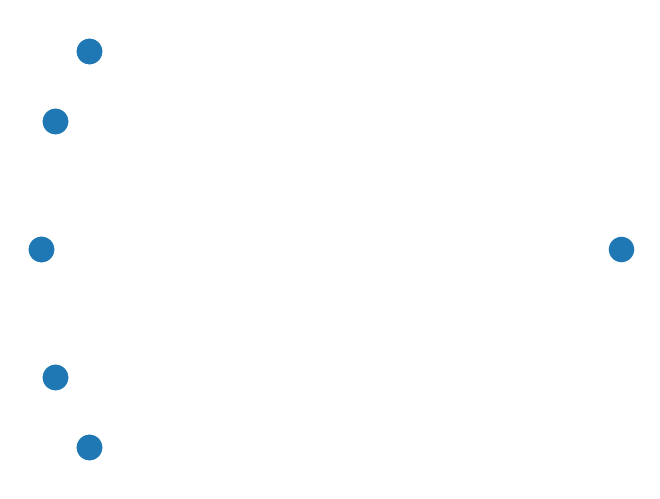

In [115]:
nx_g = g.to_networkx()
pos = nx.kamada_kawai_layout(nx_g)

nx.draw(nx_g,pos )